In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
# Download the pre-trained weights. No top means it excludes the fully connected layer it uses for classification.
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2023-11-13 16:53:29--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.112.207, 74.125.124.207, 172.217.212.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.112.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   181MB/s    in 0.5s    

2023-11-13 16:53:29 (181 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [3]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import layers
local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = InceptionV3(input_shape=(150,150,3),include_top=False, weights=None)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
pre_trained_model.load_weights(local_weights_file)

for layer in pre_trained_model.layers:
    layer.trainable = False

In [5]:
last_layer = pre_trained_model.get_layer("mixed7")
last_output = last_layer.output

In [6]:
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import layers, Model

x = layers.Flatten()(last_output)
x = layers.Dense(1024, activation="relu")(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(1, activation="sigmoid")(x)

model = Model(pre_trained_model.input, x)
model.compile(optimizer=RMSprop(learning_rate=0.0001), loss="binary_crossentropy",
             metrics=["accuracy"])

In [7]:
!wget https://storage.googleapis.com/tensorflow-1-public/course2/cats_and_dogs_filtered.zip


--2023-11-13 16:53:56--  https://storage.googleapis.com/tensorflow-1-public/course2/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.112.207, 74.125.124.207, 172.217.212.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.112.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘cats_and_dogs_filtered.zip’

cats_and_dogs_filte 100%[===================>]  65.43M   183MB/s    in 0.4s    

2023-11-13 16:53:56 (183 MB/s) - ‘cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [8]:
import zipfile
zipref = zipfile.ZipFile("/kaggle/working/cats_and_dogs_filtered.zip")
zipref.extractall("tmp/")
zipref.close()

In [9]:
train_dir = "/kaggle/working/tmp/cats_and_dogs_filtered/train"
val_dir = "/kaggle/working/tmp/cats_and_dogs_filtered/train"
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1/255)
val_datagen = ImageDataGenerator(rescale=1/255)
train_generator = train_datagen.flow_from_directory(train_dir, target_size=(150,150), batch_size=20, class_mode="binary")
val_generator = val_datagen.flow_from_directory(val_dir, target_size=(150,150), batch_size=20, class_mode="binary")

Found 2000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [10]:
history = model.fit(
            train_generator,
            validation_data = val_generator,
            steps_per_epoch = 100,
            epochs = 20,
            validation_steps = 50,
            verbose = 2)

Epoch 1/20
100/100 - 20s - loss: 0.2335 - accuracy: 0.9075 - val_loss: 0.0209 - val_accuracy: 0.9960 - 20s/epoch - 203ms/step
Epoch 2/20
100/100 - 5s - loss: 0.0346 - accuracy: 0.9880 - val_loss: 0.0094 - val_accuracy: 0.9990 - 5s/epoch - 47ms/step
Epoch 3/20
100/100 - 5s - loss: 0.0037 - accuracy: 1.0000 - val_loss: 8.4301e-04 - val_accuracy: 1.0000 - 5s/epoch - 47ms/step
Epoch 4/20
100/100 - 5s - loss: 8.4733e-04 - accuracy: 1.0000 - val_loss: 3.8201e-04 - val_accuracy: 1.0000 - 5s/epoch - 46ms/step
Epoch 5/20
100/100 - 5s - loss: 3.1586e-04 - accuracy: 1.0000 - val_loss: 1.8953e-04 - val_accuracy: 1.0000 - 5s/epoch - 48ms/step
Epoch 6/20
100/100 - 6s - loss: 2.0205e-04 - accuracy: 1.0000 - val_loss: 1.3683e-04 - val_accuracy: 1.0000 - 6s/epoch - 59ms/step
Epoch 7/20
100/100 - 5s - loss: 1.4863e-04 - accuracy: 1.0000 - val_loss: 9.8273e-05 - val_accuracy: 1.0000 - 5s/epoch - 48ms/step
Epoch 8/20
100/100 - 5s - loss: 1.2275e-04 - accuracy: 1.0000 - val_loss: 8.2308e-05 - val_accuracy:

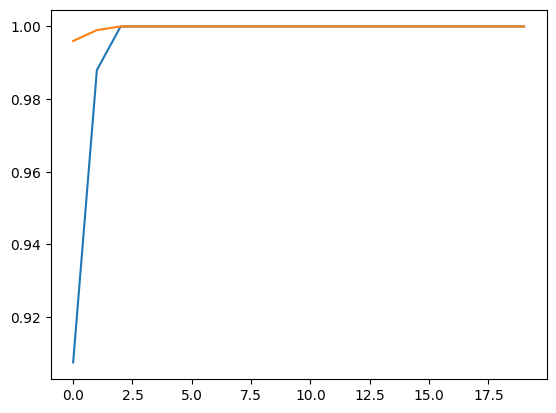

In [11]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])